In [1]:
# Cell 1: Setup & imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
print("TensorFlow version:", tf.__version__)

# Check GPU
device_name = tf.test.gpu_device_name()
print("GPU device:", device_name if device_name else "No GPU detected. Enable GPU in Runtime > Change runtime type")


TensorFlow version: 2.19.0
GPU device: /device:GPU:0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Shapes: (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


/tmp/ipython-input-2797491883.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


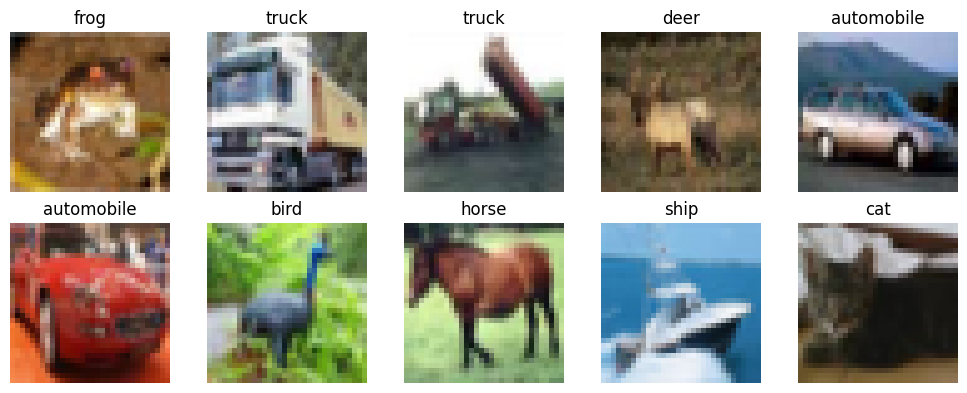

In [2]:
# Cell 2: Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("Shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# Show a few images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.tight_layout()


In [3]:
# Cell 3: Preprocess
# Normalize pixel values to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# If using sparse_categorical_crossentropy we can keep y as integer labels
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()


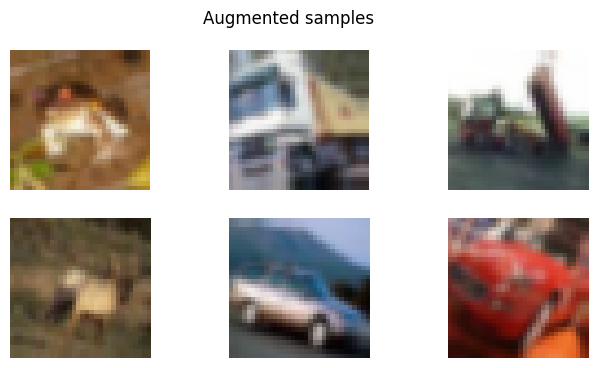

In [4]:
# Cell 4: Data augmentation using tf.keras preprocessing
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06)
], name="data_augmentation")

# Visualize augmentation example
plt.figure(figsize=(8,4))
for i in range(6):
    aug_img = data_augmentation(tf.expand_dims(x_train[i], 0), training=True)
    plt.subplot(2,3,i+1)
    plt.imshow(aug_img[0].numpy())
    plt.axis('off')
plt.suptitle("Augmented samples")
plt.show()


In [5]:
# Cell 5: Build baseline CNN model (simple and effective)
def create_baseline_model(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)  # include augmentation in model so it's applied during training
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='cifar10_cnn_baseline')
    return model

model = create_baseline_model()
model.summary()


Model: "cifar10_cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 668,842 (2.55 MB)

 Trainable params: 667,690 (2.55 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [6]:
# Cell 6: Compile and callbacks
batch_size = 64
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = callbacks.ModelCheckpoint("best_cifar10_cnn.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [7]:
# Cell 7: Train the model
history = model.fit(
    x_train, y_train_flat,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    shuffle=True
)


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3003 - loss: 2.2442

704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3004 - loss: 2.2437 - val_accuracy: 0.4912 - val_loss: 1.3881 - learning_rate: 0.0010
Epoch 2/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4805 - loss: 1.4517

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4806 - loss: 1.4516 - val_accuracy: 0.5600 - val_loss: 1.2170 - learning_rate: 0.0010
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5390 - loss: 1.2852 - val_accuracy: 0.5372 - val_loss: 1.3694 - learning_rate: 0.0010
Epoch 4/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5832 - loss: 1.1664

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5832 - loss: 1.1663 - val_accuracy: 0.5820 - val_loss: 1.3885 - learning_rate: 0.0010
Epoch 5/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6118 - loss: 1.0942

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6118 - loss: 1.0941 - val_accuracy: 0.6470 - val_loss: 1.0259 - learning_rate: 0.0010
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6320 - loss: 1.0398 - val_accuracy: 0.6404 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6434 - loss: 1.0154 - val_accuracy: 0.5682 - val_loss: 1.3727 - learning_rate: 0.0010
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6690 - loss: 0.9554 - val_accuracy: 0.6406 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 9/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6841 - loss: 0.9050

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6841 - loss: 0.9050 - val_accuracy: 0.6596 - val_loss: 1.0172 - learning_rate: 5.0000e-04
Epoch 10/50
701/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6923 - loss: 0.8798

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6923 - loss: 0.8798 - val_accuracy: 0.6764 - val_loss: 0.9405 - learning_rate: 5.0000e-04
Epoch 11/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6994 - loss: 0.8600

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6994 - loss: 0.8600 - val_accuracy: 0.7074 - val_loss: 0.8439 - learning_rate: 5.0000e-04
Epoch 12/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7044 - loss: 0.8500 - val_accuracy: 0.6828 - val_loss: 0.9446 - learning_rate: 5.0000e-04
Epoch 13/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7118 - loss: 0.8253

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7118 - loss: 0.8253 - val_accuracy: 0.7386 - val_loss: 0.7604 - learning_rate: 5.0000e-04
Epoch 14/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7180 - loss: 0.8123 - val_accuracy: 0.6862 - val_loss: 0.9092 - learning_rate: 5.0000e-04
Epoch 15/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7215 - loss: 0.8043 - val_accuracy: 0.7312 - val_loss: 0.7876 - learning_rate: 5.0000e-04
Epoch 16/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7256 - loss: 0.7905

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7256 - loss: 0.7905 - val_accuracy: 0.7490 - val_loss: 0.7173 - learning_rate: 5.0000e-04
Epoch 17/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7298 - loss: 0.7832 - val_accuracy: 0.7406 - val_loss: 0.7936 - learning_rate: 5.0000e-04
Epoch 18/50
702/704 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7349 - loss: 0.7719

704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7349 - loss: 0.7720 - val_accuracy: 0.7686 - val_loss: 0.6665 - learning_rate: 5.0000e-04
Epoch 19/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7302 - loss: 0.7779 - val_accuracy: 0.7364 - val_loss: 0.7648 - learning_rate: 5.0000e-04
Epoch 20/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7385 - loss: 0.7517 - val_accuracy: 0.7574 - val_loss: 0.7175 - learning_rate: 5.0000e-04
Epoch 21/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7387 - loss: 0.7499 - val_accuracy: 0.7114 - val_loss: 0.8673 - learning_rate: 5.0000e-04
Epoch 22/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7500 - loss: 0.7197 - val_accuracy: 0.7568 - val_loss: 0.7222 - learning_rate: 2.5000e-04
Epoch 23/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7506 - loss: 0.7166 - val_accuracy: 0.7556 - val_loss: 0.7198 - learning_rate: 2.5000e-04
Epoch 24/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - a

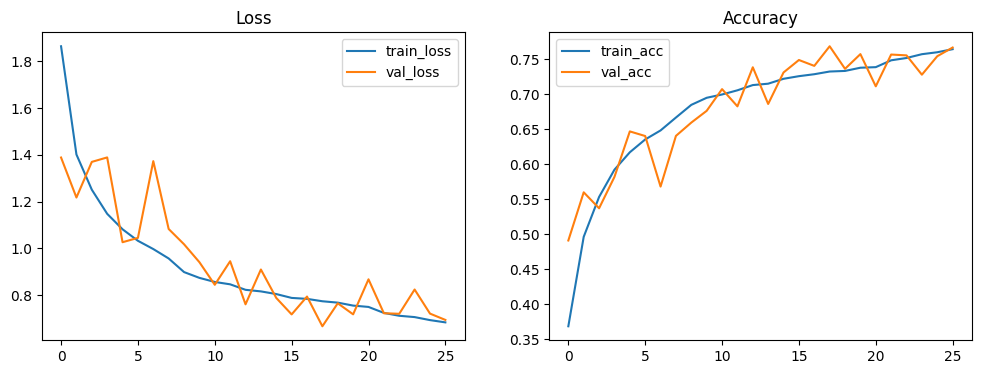

In [8]:
# Cell 8: Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


313/313 - 3s - 10ms/step - accuracy: 0.7584 - loss: 0.6991
Test loss: 0.6991, Test accuracy: 0.7584
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


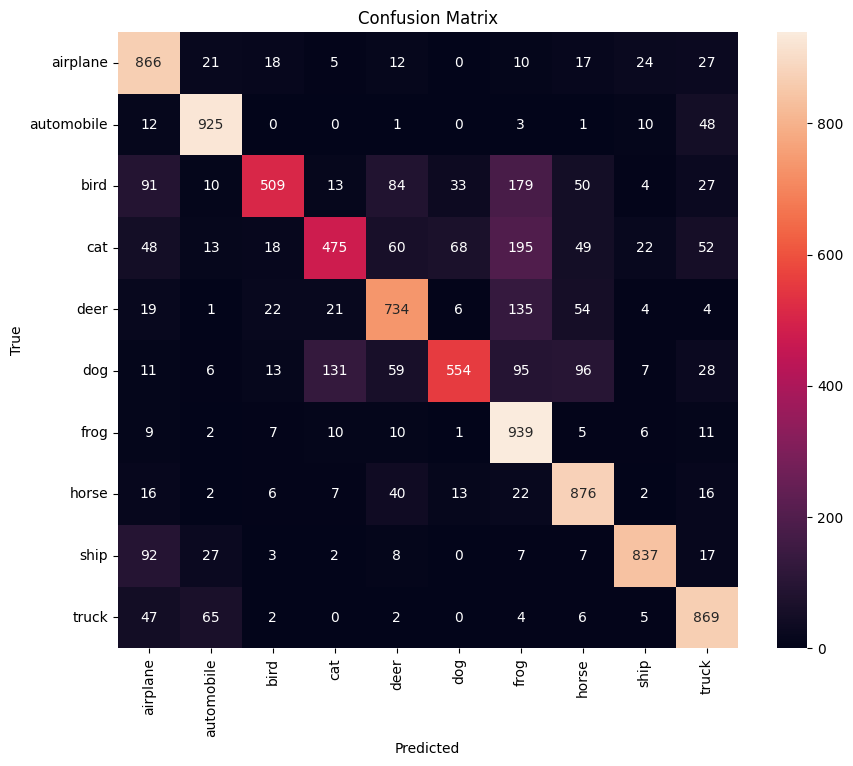

              precision    recall  f1-score   support

    airplane       0.72      0.87      0.78      1000
  automobile       0.86      0.93      0.89      1000
        bird       0.85      0.51      0.64      1000
         cat       0.72      0.47      0.57      1000
        deer       0.73      0.73      0.73      1000
         dog       0.82      0.55      0.66      1000
        frog       0.59      0.94      0.73      1000
       horse       0.75      0.88      0.81      1000
        ship       0.91      0.84      0.87      1000
       truck       0.79      0.87      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.75     10000
weighted avg       0.77      0.76      0.75     10000



In [9]:
# Cell 9: Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test_flat, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# Predictions and confusion matrix
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_flat, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_flat, y_pred, target_names=class_names))


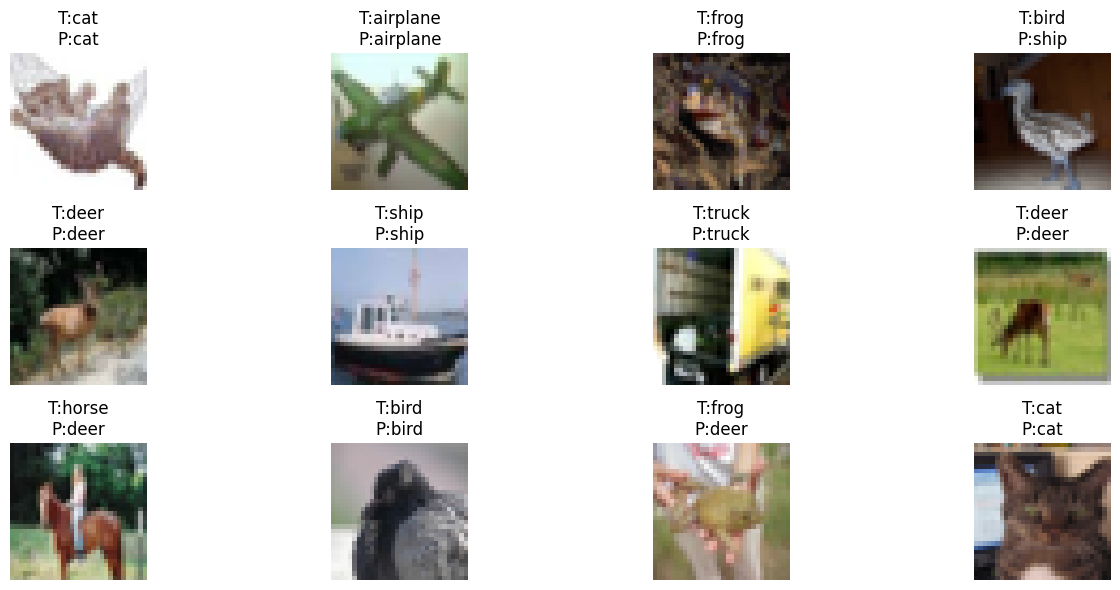

In [10]:
# Cell 10: display some predictions
n = 12
indices = np.random.choice(len(x_test), n, replace=False)
plt.figure(figsize=(14,6))
for i, idx in enumerate(indices):
    plt.subplot(3,4,i+1)
    plt.imshow(x_test[idx])
    true_label = class_names[y_test_flat[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"T:{true_label}\nP:{pred_label}")
    plt.axis('off')
plt.tight_layout()


In [12]:
# ✅ Updated model saving for Keras 3
# Option 1: Recommended new Keras format (.keras)
model.save("final_cifar10_model.keras")
print("✅ Saved model in new Keras format: final_cifar10_model.keras")

# Option 2: Still valid legacy format (.h5)
model.save("final_cifar10_model.h5")
print("✅ Also saved model in legacy HDF5 format (optional).")

# No need for 'save_format' argument anymore


✅ Saved model in new Keras format: final_cifar10_model.keras
✅ Also saved model in legacy HDF5 format (optional).
